In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import tifffile as tfl
import h5py
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/Landslide')

In [ ]:
%ls

best_model.hdf5  TrainData/


In [ ]:
folder_list = sorted(os.listdir('/content/drive/MyDrive/Landslide/TrainData/img'))
mask_folder_list =sorted(os.listdir('/content/drive/MyDrive/Landslide/TrainData/mask'))
#mask_folder_list.remove('collection.json')


In [ ]:
print(f'Image name is {folder_list[110]}')
print(f'Mask name is {mask_folder_list[110]}')
print(f'Number of items in Folder List {len(folder_list)}')
print(f'Number of items in mask list {len(mask_folder_list)}')

Image name is image_1099.h5
Mask name is mask_1099.h5
Number of items in Folder List 3798
Number of items in mask list 3798


In [ ]:
# # Dataloader for Pytorch
# dataset_dir='D:/Landslide/TrainData/img/'
# mask_dir='D:/Landslide/TrainData/mask/'

# class data_loader():
#     def __init__(self,dataset_dir,mask_dir):
#         self.dataset_dir = dataset_dir
#         self.mask_dir = mask_dir
        
#         folder_list = os.listdir(self.dataset_dir)
#         mask_folder_list = os.listdir(self.mask_dir)

#     def __getitem__(self,idx):
#         image = self.get_image(folder_list[idx])
#         mask = self.get_mask_image(mask_folder_list[idx])
    
#         return image,mask
    
#     def get_image(self,folder_dir):
#         image = h5py.File(dataset_dir+folder_dir,'r')
#         image = np.array(image.get('img'))
# #         image = tfl.imread(dataset_dir+folder_dir)
        
        
#         return image
    
#     def get_mask_image(self,folder_dir):
#         image = h5py.File(mask_dir+folder_dir,'r')
#         image = np.array(image.get('mask'))
# #         label = np.array(Image.open(mask_dir+folder_dir+'/labels.tif'))
        
#         return image
    
# training_data = data_loader(dataset_dir,mask_dir)

# for i in range(10):
#     n = np.random.randint(1,100)
#     fig,(ax1,ax2)= plt.subplots(1,2,figsize=(10,10))
#     ax1.imshow(training_data[n][0][:,:,1])
#     ax2.imshow(training_data[n][1])

# Tensorflow DataLoader

In [ ]:

dataset_dir='/content/drive/MyDrive/Landslide/TrainData/img/'
mask_dir='/content/drive/MyDrive/Landslide/TrainData/mask/'

class data_loader(keras.utils.Sequence):
    def __init__(self, batch_size, img_size,num_classes,dataset_dir,mask_dir):
        self.batch_size = batch_size
        self.img_size = img_size
        self.dataset_dir = dataset_dir
        self.mask_dir = mask_dir
        self.num_classes= num_classes
        self.folder_list = sorted(os.listdir(self.dataset_dir))
        self.mask_folder_list = sorted(os.listdir(self.mask_dir))


    def __len__(self):
        return len(self.folder_list)

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.folder_list[i : i + self.batch_size]
        batch_target_img_paths = self.mask_folder_list[i : i + self.batch_size]

        # load images
        # x = np.zeros((self.batch_size,) + self.img_size + (14,), dtype="float32")
        x = np.zeros((self.batch_size,) + self.img_size + (2,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = self.get_image(self.dataset_dir+path)
            x[j] = img

        # load masks
        y = np.zeros((self.batch_size,) + self.img_size, dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = self.get_mask_image(self.mask_dir+path)
            y[j] = img  

        return x,y



    def get_image(self,folder_dir):
        image = h5py.File(folder_dir,'r')
        image = np.array(image.get('img'))
        image = image[:,:,12:]
#         image = tfl.imread(dataset_dir+folder_dir)
        
        
        return image
    
    def get_mask_image(self,folder_dir):
        image = h5py.File(folder_dir,'r')
        image = np.array(image.get('mask'))
#         label = np.array(Image.open(mask_dir+folder_dir+'/labels.tif'))
        
        return image


In [ ]:
# sat_data1 = data_loader(20,(128,128),14,dataset_dir,mask_dir)
# val_gen = data_loader(10,(128,128),14,dataset_dir,mask_dir)

sat_data1 = data_loader(20,(128,128),2,dataset_dir,mask_dir)
val_gen = data_loader(10,(128,128),2,dataset_dir,mask_dir)

In [ ]:
x,y = sat_data1[0]
x.shape,y.shape

((20, 128, 128, 2), (20, 128, 128))

In [ ]:
  # x,y = sat_data1[30]
# print(x.shape)
# print(y.shape)
len(val_gen),len(sat_data1)

(3798, 3798)

(20, 128, 128, 2)
(20, 128, 128)


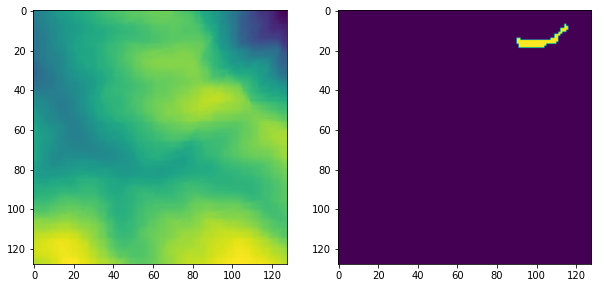

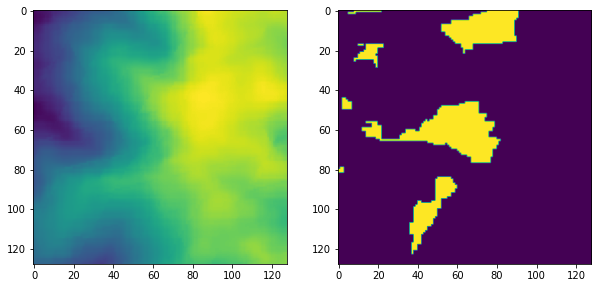

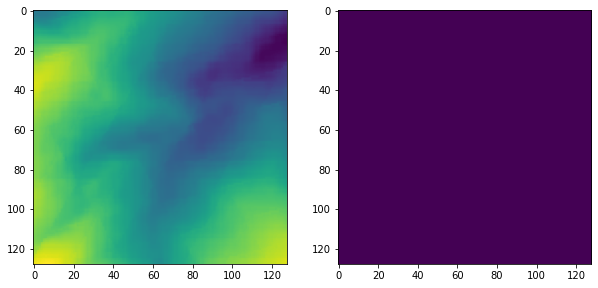

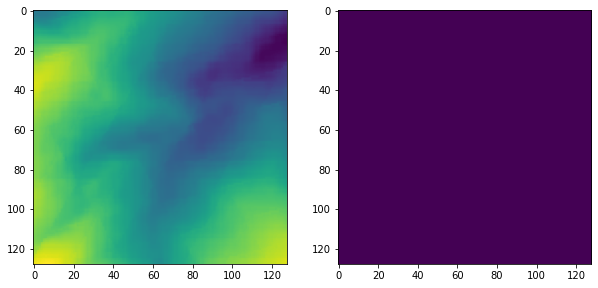

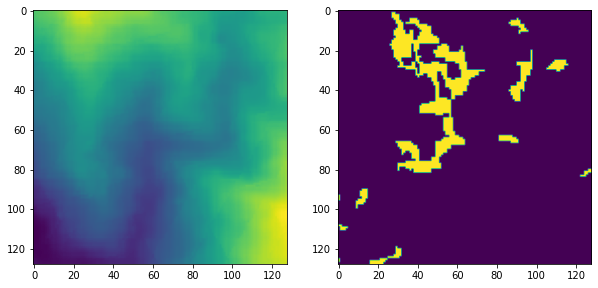

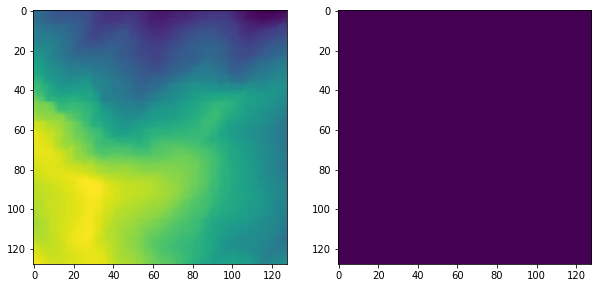

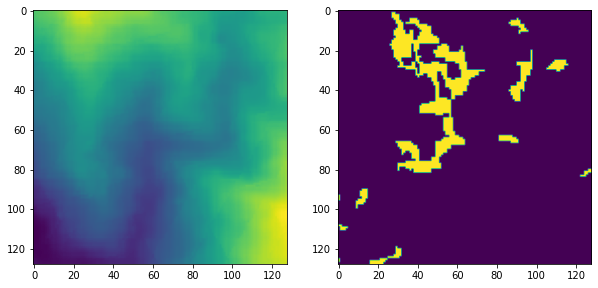

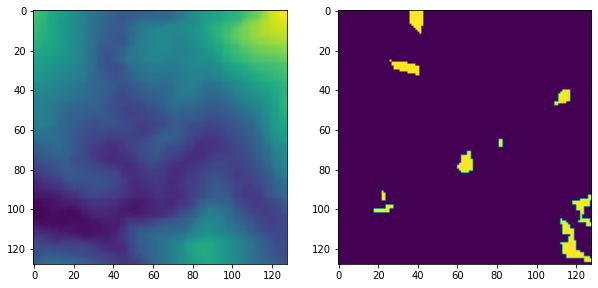

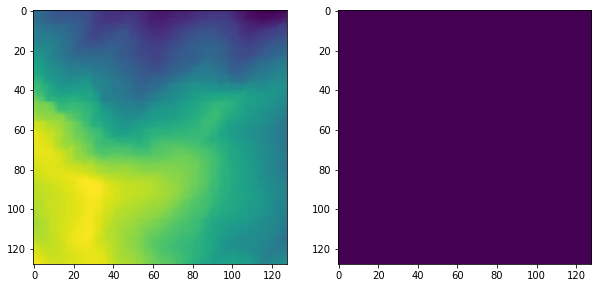

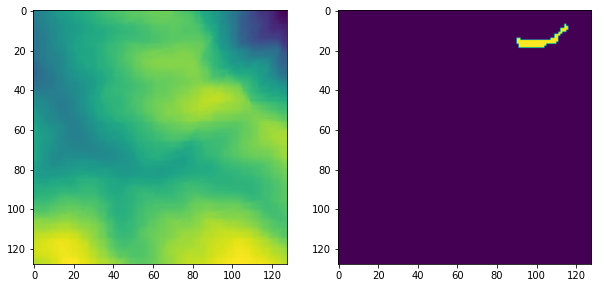

In [ ]:
x,y = sat_data1[30]
print(x.shape)
print(y.shape)
for i in range(10):
    n = np.random.randint(1,10)
    fig,(ax1,ax2)= plt.subplots(1,2,figsize=(10,10))
    # ax1.imshow(x[n][0][:,:,1])
    ax1.imshow(x[n][:,:,1])
    ax2.imshow(y[n])

# Loss Function and Metrics

In [ ]:
#Loss function
def dice_coef(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)  # -------------------------------------------------- explicit cast
  y_true = K.flatten(y_true)
  y_pred = K.flatten(y_pred)
  intersection = K.sum(y_true * y_pred)
  return 2.0 * intersection / (K.sum(y_true) + K.sum(y_pred) + 1.)

## function for measuring loss value
def dice_coef_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)  # -------------------------------------------------- explicit cast
  return 1.0 - dice_coef(y_true, y_pred)

## Merge loss
def bce_dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)  # -------------------------------------------------- explicit cast
  a = 0.5
  b = 1-a
  loss = a * K.binary_crossentropy(y_true, y_pred) + b * dice_coef_loss(y_true, y_pred)
  return loss

#Metrics 
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Unet Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def UNet(num_classes = 1,
         image_size = 128, 
        #  img_channels = 14,
         img_channels = 2,
         activation_fn = 'sigmoid'
        ):

    inputs = Input((image_size, image_size, img_channels))
    s = Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation=activation_fn)(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
    
    return model



def DeepUNet(num_classes=1,
             image_size=128,
            #  img_channels=14,
             img_channels=2,
             activation_fn = 'sigmoid',
             n_filters_start=32,
             growth_factor=2,
             upconv=True
            ):
    """
    Reference - https://github.com/reachsumit/deep-unet-for-satellite-image-segmentation/blob/master/unet_model_deeper.py
    """
    
    droprate=0.25
    n_filters = n_filters_start
    inputs = Input((image_size, image_size, img_channels))
    
#     s = Lambda(lambda x: x / 255)(inputs)
    
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(droprate)(pool1)

    n_filters *= growth_factor
    pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(droprate)(pool2)

    n_filters *= growth_factor
    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(droprate)(pool3)

    n_filters *= growth_factor
    pool3 = BatchNormalization()(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_0)
    pool4_0 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    pool4_0 = Dropout(droprate)(pool4_0)

    n_filters *= growth_factor
    pool4_0 = BatchNormalization()(pool4_0)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_0)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_1)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    pool4_1 = Dropout(droprate)(pool4_1)

    n_filters *= growth_factor
    pool4_1 = BatchNormalization()(pool4_1)
    conv4_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_1)
    conv4_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_2)
    pool4_2 = MaxPooling2D(pool_size=(2, 2))(conv4_2)
    pool4_2 = Dropout(droprate)(pool4_2)

    n_filters *= growth_factor
    pool4_2 = BatchNormalization()(pool4_2)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_2)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Dropout(droprate)(conv5)

    n_filters //= growth_factor
    if upconv:
        up6 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv5), conv4_2])
    else:
        up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4_2])
    up6 = BatchNormalization()(up6)
    conv6 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = Dropout(droprate)(conv6)

    n_filters //= growth_factor
    if upconv:
        up6_1 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6), conv4_1])
    else:
        up6_1 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv4_1])
    up6_1 = BatchNormalization()(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_1)
    conv6_1 = Dropout(droprate)(conv6_1)

    n_filters //= growth_factor
    if upconv:
        up6_2 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_1), conv4_0])
    else:
        up6_2 = concatenate([UpSampling2D(size=(2, 2))(conv6_1), conv4_0])
    up6_2 = BatchNormalization()(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_2)
    conv6_2 = Dropout(droprate)(conv6_2)

    n_filters //= growth_factor
    if upconv:
        up7 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_2), conv3])
    else:
        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6_2), conv3])
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(droprate)(conv7)

    n_filters //= growth_factor
    if upconv:
        up8 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    else:
        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(droprate)(conv8)

    n_filters //= growth_factor
    if upconv:
        up9 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    else:
        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    up9 = BatchNormalization()(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(num_classes, (1, 1), activation=activation_fn)(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    
    return model


# Unet Model Fitting

In [ ]:
model = UNet()
# model.summary()
opt = keras.optimizers.Adam()
model.compile(loss=bce_dice_loss, optimizer=opt,metrics=['acc',f1_m,precision_m, recall_m])

checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)


hisotry = model.fit(sat_data1,validation_data = val_gen,epochs= 10 ,verbose=1,callbacks=[checkpoint])

model.save('/content/U_net.h5')


Epoch 1/10


Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7fb3ff891a70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/function.py", line 315, in __del__
    context.remove_function(self.name)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/context.py", line 2645, in remove_function
    context().remove_function(name)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/context.py", line 1315, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
KeyboardInterrupt: 


KeyboardInterrupt: ignored

# Deep Unet Model fitting

In [ ]:
Deep_model = DeepUNet() 
# opt = keras.optimizers.Adam(learning_rate=0.0001)
opt = keras.optimizers.Adam()
Deep_model.compile(loss=bce_dice_loss, optimizer=opt,metrics=['acc',f1_m,precision_m, recall_m])

checkpoint = ModelCheckpoint("best_model.hdf5", monitor='f1_m', verbose=1,
    save_best_only=True, mode='auto', period=1)

hisotry2 = Deep_model.fit(sat_data1,validation_data = val_gen,epochs=10 ,verbose=1,callbacks=[checkpoint])

Deep_model.save('/content/Deep_U_net.h5')

Epoch 1/10
3798/3798 [==============================] - ETA: 0s - loss: 0.5035 - acc: 0.9988 - f1_m: 1.4146e-05 - precision_m: 7.7899e-06 - recall_m: 7.7568e-05

In [ ]:
fig,((ax11,ax12,ax13,ax14),(ax21,ax22,ax23,ax24)) = plt.subplots(2,4,figsize=(20,15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')


ax21.plot(history2.history['loss'])
ax21.plot(history2.history['val_loss'])
ax21.title.set_text('LSTM model loss')
ax21.set_ylabel('loss')
ax21.set_xlabel('epoch')
ax21.legend(['train', 'validation'], loc='upper left')

ax22.plot(history2.history['precision_m'])
ax22.plot(history2.history['val_precision_m'])
ax22.set_title('Deep Unet model precision')
ax22.set_ylabel('precision')
ax22.set_xlabel('epoch')
ax22.legend(['train', 'validation'], loc='upper left')

ax23.plot(history2.history['recall_m'])
ax23.plot(history2.history['val_recall_m'])
ax23.set_title('Deep Unet model recall')
ax23.set_ylabel('recall')
ax23.set_xlabel('epoch')
ax23.legend(['train', 'validation'], loc='upper left')

ax24.plot(history2.history['f1_m'])
ax24.plot(history2.history['val_f1_m'])
ax24.set_title('Deep Unet model f1')
ax24.set_ylabel('f1')
ax24.set_xlabel('epoch')
ax24.legend(['train', 'validation'], loc='upper left')


In [ ]:
model_unet=keras.models.load_model('/content/U_net.h5',
                                 custom_objects={ 'bce_dice_loss': bce_dice_loss, 
                                                  'dice_coef':dice_coef,
                                                 'f1_m':f1_m,
                                                 'precision_m':precision_m,
                                                 'recall_m':recall_m} )

model_deep_unet = keras.models.load_model('/content/Deep_U_net.h5',
                                 custom_objects={ 'bce_dice_loss': bce_dice_loss, 
                                                  'dice_coef':dice_coef,
                                                 'f1_m':f1_m,
                                                 'precision_m':precision_m,
                                                 'recall_m':recall_m} )

In [ ]:
loss,accuracy,f1,precision,recall = model_unet.evaluate(X_test,y_test,verbose=0)
print(f"Unet Model \nprecision :{precision*100} \naccuracy :{accuracy *100} \nf1 score :{f1*100} \nrecall :{recall*100} \nloss : {loss}")
print('-------------------------------------')
loss1,accuracy1,f1_a,precision1,recall1 = model_deep_unet.evaluate(X_test,y_test,verbose=0)
print(f"Deep Unet Model \nprecision :{precision1*100} \naccuracy : {accuracy1*100} \nf1 score :{f1_a*100} \nrecall :{recall1*100} \nLoss :{loss1}")